# CS 109A Data Science: Midterm
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, October 15th, 2016 at 09:00am

### Import libraries:

In [146]:
# Panda and Numpy
import numpy as np
import pandas as pd

# SKlearn libraries
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn.cross_validation import train_test_split as sk_split
from sklearn.neighbors import KNeighborsRegressor as KNN
import sklearn.preprocessing as Preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

# Statsmodel
from statsmodels.regression.linear_model import OLS
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.formula.api as smf

# Various 
import itertools as it
import statsmodels.api as sm
import scipy as sp
from itertools import combinations
import math

# Ploting libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

# Web scraping libraries
import urllib2
from bs4 import BeautifulSoup
%matplotlib inline


## Basic Information

### Name

[Hagmann, Tim]

### Course Number

[CS 109a]

## Part I: Scrape meteor data


In [3]:
## Scrape the data from the table at below url
url = "https://cs109alabs.github.io/lab_files/"

page = urllib2.urlopen(url).read()
soup = BeautifulSoup(page)


In [4]:
## Export data to a datafile
with open('data/2016-10-15_meteor_data.csv', 'w') as f:
    for tr in soup.find_all('tr')[1:]:
        tds = tr.find_all('td')
        f.write("%s,%s,%s,%s\n"%(tds[0].text, tds[1].text, tds[2].text,tds[3].text))


In [73]:
## Add variable names
var_names = ["time", "x_coord", "y_coord", "z_coord"]

# Read the CSV file
df_meteor = pd.read_csv('data/2016-10-15_meteor_data.csv', names = var_names)

# Print head of the data 
print df_meteor.shape
df_meteor.head()

# Sort dataframe
df_meteor = df_meteor.sort_values(by = 'z_coord', ascending = False)

(130, 4)


The meteor dataframe has a row length of 130 and contains 4 variables. These are: Time, X-Coordinate, Y-Coordinate and the Z-Coordinate (i.e., altitude).

In [74]:
# Extract the above variable data
x = df_meteor['x_coord']
y = df_meteor['y_coord']
z = df_meteor['z_coord']
time = df_meteor['time']

In [233]:
# Read population data
df_pop = pd.read_csv('data/pop_data.csv')

# Print head of the data 
print df_pop.shape
df_pop.head()

(2417, 5)


,residents,bed,bath,x,y
0,3.0,4,3,7201.60,6752.56
1,2.0,2,1,7079.68,6622.32
2,4.0,2,1,7154.40,6683.28
3,2.0,1,2,7093.44,6680.56
4,1.0,2,2,7198.72,6674.96


The population dataset has a row length of 2'417 and contains 5 variables. These are: Residents, Bed, Bath, X-Coordinate and Y-Coordinate.

## Part II: Plot available meteor data


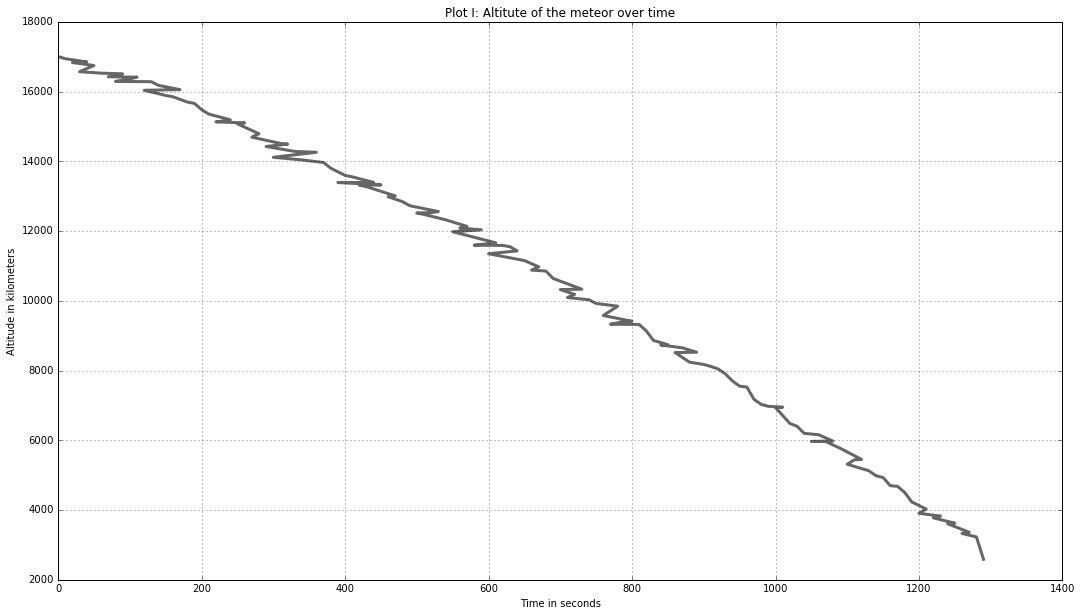

In [76]:
# Hight over time
plt.figure(figsize=(18, 10))
plt.plot(time, z, color="black", alpha=0.6, linewidth=3)
plt.xlabel('Time in seconds'); plt.ylabel('Altitude in kilometers')
plt.title('Plot I: Altitute of the meteor over time')
plt.grid()


In [77]:
print "Distance to impact: ", np.min(z), "kilometers"

Distance to impact:  2586.47864346 kilometers


The above plot shows the rapid loss of altitude the meteor shows. There are only 2'586 kilometers till impact. 

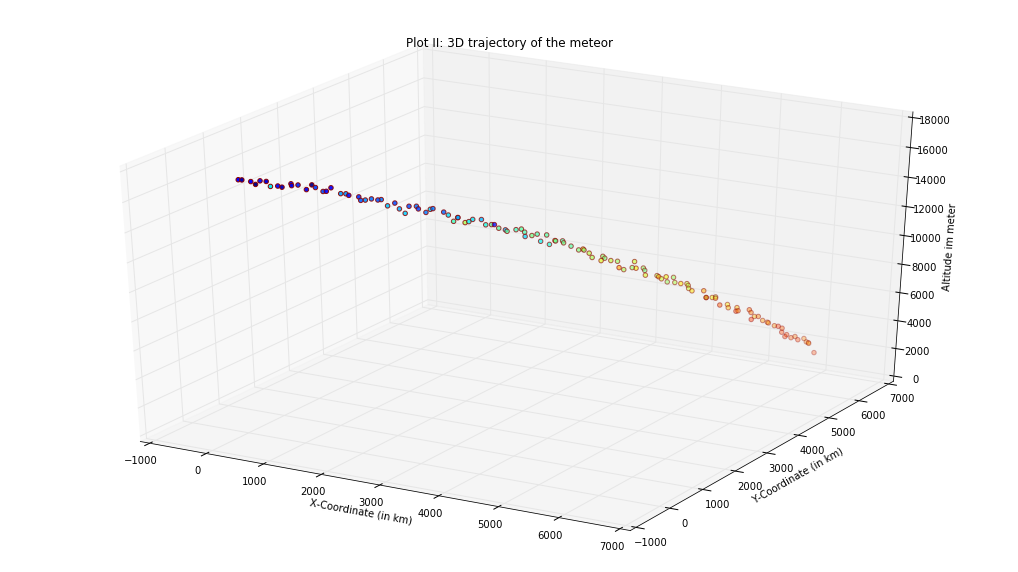

In [78]:
# Visualize trajectory of the meteor in a 3d plot 
fig = plt.figure(figsize = (18, 10))
ax = plt.axes(projection = '3d')

c = x - y
ax.set_title('Plot II: 3D trajectory of the meteor')
ax.set_xlabel('X-Coordinate (in km)')
ax.set_ylabel('Y-Coordinate (in km)')
ax.set_zlabel('Altitude im meter')

ax.scatter(x, y, z, c = c, color = "darkred")


Looking at the trajectory of the meteor shows, that the meteor has a clear trajectory on a X-Y grid that can be followed to the zero altitude point, i.e., the impact site. The next interesting plot is showing the distribution of the population vs. the current location of the meteor. 

In [2]:
# Population plot
fig = plt.figure(figsize = (15, 15))
ax = plt.axes()

dot_size=df_pop['residents'].values * 10
ax.scatter(df_pop['x'].values, 
           df_pop['y'].values, 
           s=dot_size,
           c=dot_size,
           lw=0)
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.set_title('Plot III: Plot of the population')

plt.grid()

# Add current location of the meteor
ax.plot(x[z == np.min(z)], y[z == np.min(z)], 'or', c="black")



NameError: name 'plt' is not defined

The plot above shows the distribution of the popuation as well as the location of the meteor. It can be seen that the population is spread all over the planet with a couple of population hotspots. The population size is indicated trough the color and size of the population points. The meteor is the black dot on the bottom left side of the picture.

## Part III: Modelling of the meteors trajectory

### Assumptions:
- Wind has no impact on the meteors path
- No planetary rotation, i.e., the earth stands still

The first part is to split the dataset into a training and testing part. This is to avoid overfitting and spurios patterns that are only present in the dataset. Because of the small dataset of only 130 observations we split the data at 30/70, i.e., we're using the majority of the data (70%) to build the model. 

###  Preparation:

In [237]:
## Split the dataset
np.random.seed(123) # Set random seed
x_train, x_test = train_test_split(x, test_size = 0.3)

## Split the variables
x_train = x.iloc[x_train.index.values]
x_test = x.iloc[x_test.index.values]
y_train = y.iloc[x_train.index.values]
y_test = y.iloc[x_test.index.values]
z_train = z.iloc[x_train.index.values]
z_test = z.iloc[x_test.index.values]

## Transform to numpy 
x_train = x_train.values
x_test = x_test.values
y_train = y_train.values
y_test = y_test.values
z_train = z_train.values
z_test = z_test.values

## Reshaping
x_train=x_train.reshape(-1, 1)
x_test=x_test.reshape(-1, 1)
y_test=y_test.reshape(-1, 1)
y_train=y_train.reshape(-1, 1)
z_train=z_train.reshape(-1, 1)
z_test=z_test.reshape(-1, 1)

## Create bew Z-Values
# (Those are the values that describe the final path of the meteroit till impact, i.e., the last point is zero)
new_z = np.array(sorted(np.arange(0, round(np.min(z_test), 0), 10), reverse = True))
new_z = new_z.reshape(-1, 1)


In order to predict x and y at z = 0 (i.e., the impact site), we have to fit two models. Otherwise we're not getting a clear impact coordinate as we have to predict 2 values. The X-Coordinates and the 
Y-Coordinates of the impact site. This means we're building two regression models.

Because of the straight trajectory of the meteor (seen in plot II) we're building a multiple linear regression model. This model is very good in capturing linear relationships. However, because the picture indicates that the trajectory is not following a straigth line, we're assuming a polynomial relationship, i.e., it appears that the meteor is loosing height because of the gravitational pull of the planet. 

In [238]:
### Fit sklearn multiple linear regression model
## Creating Z training matrix
Z = z_train
poly = Preprocessing.PolynomialFeatures(degree = 3) # Generate a model of polynomial features
Z_ = poly.fit_transform(Z)                          # Transform the x data for proper fitting

# Create prediction matrix
Z_predict = z_test
Z_predict = poly.fit_transform(Z_predict)
new_z_predict = poly.fit_transform(new_z)


### Predicting the X-Coordinates:

In [239]:
## Actual regression
reg = Lin_Reg()
reg.fit(Z_, x_train)

# Get coefficients from fitted model
w = reg.coef_
c = reg.intercept_

## Get prediction
x_predict = reg.predict(Z_predict)
x_new_pred = reg.predict(new_z_predict)

# Print training and test R^2
regscore = reg.score(Z_, x_train)
regtestscore = reg.score(Z_predict, x_test)
print "Train score    | Test score"
print regscore, "|", regtestscore


Train score    | Test score
0.999268399661 | 0.999242397196


Testing the model shows that the R2 of the model very good. The R2 on the test set is even better than the one on the training set. 

In [240]:
# Sorting values
df_pred = pd.DataFrame(np.hstack((z_test, x_predict, x_test)))
df_pred = df_pred.sort_values(0, ascending = False)
z_test_sort = df_pred.iloc[:, 0].values
x_predict_sort = df_pred.iloc[:, 1].values
x_test_sort = df_pred.iloc[:, 2].values


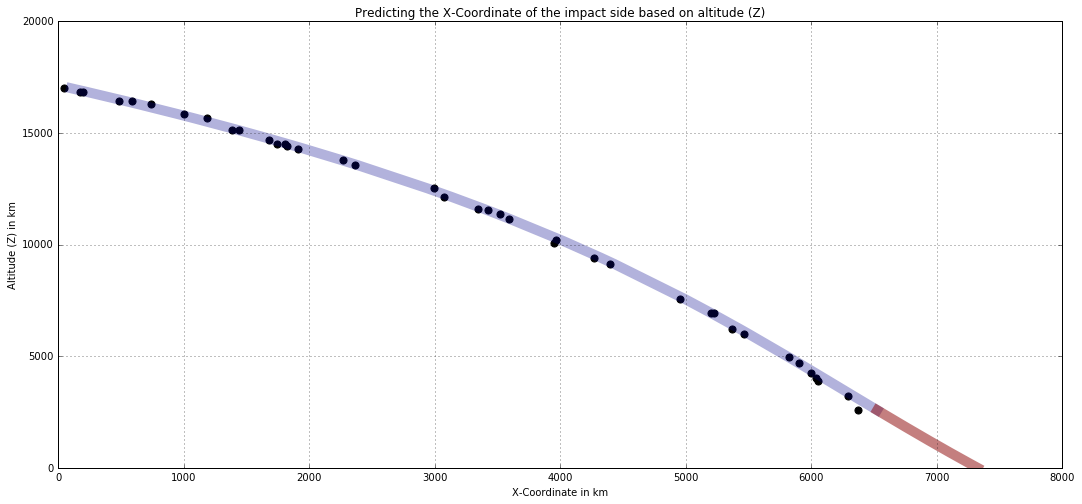

In [241]:
# Plot outputs x vs z
fig = plt.figure(figsize = (18, 8))
ax = fig.add_subplot(111)
plt.scatter(x_test_sort, z_test_sort, color = 'black', s = 50, alpha = 1)
plt.plot(x_predict_sort, z_test_sort, color = 'darkblue', alpha = 0.3, linewidth = 10)
plt.plot(x_new_pred, new_z, color = 'darkred', alpha = 0.5, linewidth = 10)

ax.set_ylim(ymin = 0); ax.set_xlim(xmin = 0)
ax.set_ylabel('Altitude (Z) in km'); ax.set_xlabel('X-Coordinate in km')
ax.set_title('Predicting the X-Coordinate of the impact side based on altitude (Z)')
plt.grid()
fig.show()


**NOTE:** In order to make the graph more readable and intituive, the axis is switched around, i.e., we're predicting the X-Coordinate with the help of the altitude, i.e., the Z-Coordinates. Normally the graph axis would be the other way round.

Legend: 
- The black dots indicate the actual measurements from the testing set
- The blue line shows the fitted model. 
- The red line shows the predicet path of the meteroit, 

The above plot shows the current as well as the projected trajectory of the meteor. The impact site appears to be around the 7'300 km mark. Furthermore, it can be seen that the trajectory of the meteor might descend even further. That could indicate a higher polynomial. When testing this it can actually be seen that a polynomial of 5 performs actually even better on the test set than a polynomial of 3. However, because of the small data set we stick to the more conservative polynomial of 3. The higher degree the polynomial the higher the chance for an overfitt. 

### Predicting the Y-Coordinates:

In [242]:
## Actual regression
reg = Lin_Reg()
reg.fit(Z_, y_train)

# Get coefficients from fitted model
w = reg.coef_
c = reg.intercept_

## Get prediction
y_predict = reg.predict(Z_predict)
y_new_pred = reg.predict(new_z_predict)

# Print training and test R^2
regscore = reg.score(Z_, y_train)
regtestscore = reg.score(Z_predict, y_test)
print "Train score    | Test score"
print regscore, "|", regtestscore


Train score    | Test score
0.997581148178 | 0.998134916545


We get similar R2 values as with the model of the X-Coordinates, i.e., a very good testscore 0.9981. That means, that the model is able to explain around 99.82% of the variation in the training data.

In [243]:
# Sorting values
df_pred = pd.DataFrame(np.hstack((z_test, y_predict, y_test)))
df_pred = df_pred.sort_values(0, ascending = False)
z_test_sort = df_pred.iloc[:, 0].values
y_predict_sort = df_pred.iloc[:, 1].values
y_test_sort = df_pred.iloc[:, 2].values


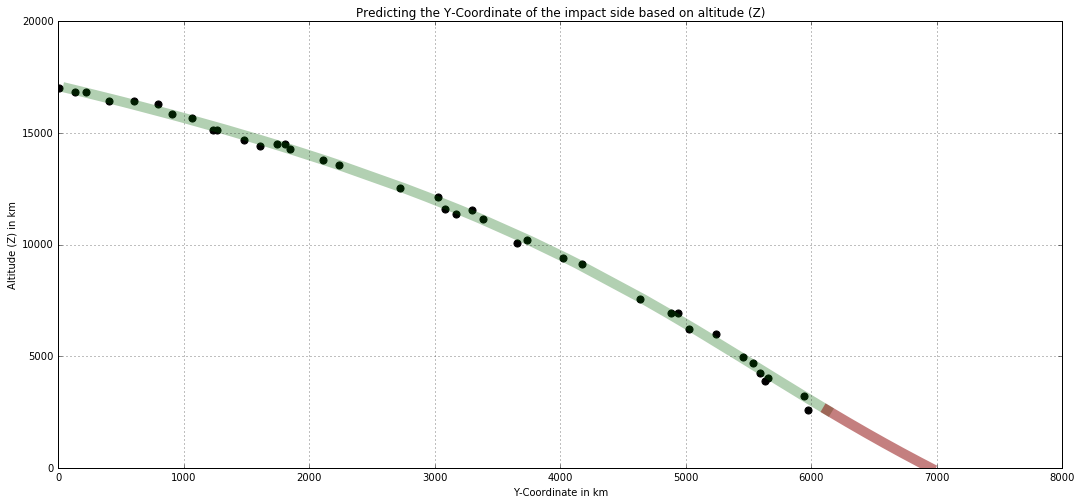

In [244]:
# Plot outputs x vs z
fig = plt.figure(figsize = (18, 8))
ax = fig.add_subplot(111)
plt.scatter(y_test_sort, z_test_sort, color = 'black', s = 50, alpha = 1)
plt.plot(y_predict_sort, z_test_sort, color = 'darkgreen', alpha = 0.3, linewidth = 10)
plt.plot(y_new_pred, new_z, color = 'darkred', alpha = 0.5, linewidth = 10)

ax.set_ylim(ymin = 0); ax.set_xlim(xmin = 0)
ax.set_ylabel('Altitude (Z) in km'); ax.set_xlabel('Y-Coordinate in km')
ax.set_title('Predicting the Y-Coordinate of the impact side based on altitude (Z)')
plt.grid()
fig.show()


**NOTE:** In order to make the graph more readable and intituive, the axis is switched around, i.e., we're predicting the Y-Coordinate with the help of the altitude, i.e., the Z-Coordinate. Normally the graph axis would be the other way round.

Legend: 
- The black dots indicate the actual measurements from the testing set
- The green line shows the fitted model. 
- The red line shows the predicet path of the meteroit, 

The above plot shows a similiar pattern to the x-coordinate model. The impact site appears to be slighly below the 7'000 km mark. 

** Get the X and Y Point at altitute zero**

In [245]:
df_prediction = pd.DataFrame(np.hstack((new_z, x_new_pred, y_new_pred)))
df_prediction.columns =  ["Altitude (Z)", "X_Coord", "Y_Coord"]
df_prediction.tail()


,Altitude (Z),X_Coord,Y_Coord
254,40.0,7310.580865,6934.020514
255,30.0,7313.847244,6937.459956
256,20.0,7317.115429,6940.901948
257,10.0,7320.385424,6944.346495
258,0.0,7323.657236,6947.793603


In [246]:
n = df_prediction.shape[0] - 1
print 'It can be seen that the model predicts the meteroid impact at coordinate X:', df_prediction.iloc[n, 1], 'and Y:', df_prediction.iloc[n, 2]


It can be seen that the model predicts the meteroid impact at coordinate X: 7323.65723601 and Y: 6947.79360291


## Part IV: People in the impact region


In [249]:
## Reduce dataset to interecting columns
df_pop = df_pop[['residents','x','y']]
df_pop.head()

## Missings
print 'Missing X-Coordinates: ', df_pop['x'].isnull().sum()
print 'Missing Y-Coordinates: ',df_pop['y'].isnull().sum()
print 'Missing residents ',df_pop['residents'].isnull().sum()

## Fill missing residents with zeros
df_pop['residents'] = df_pop['residents'].fillna(0)

## Check
print 'Check: Missing residents ',df_pop['residents'].isnull().sum()


Missing X-Coordinates:  0
Missing Y-Coordinates:  0
Missing residents  0
Check: Missing residents  0


In order to model total number of people that will most likely be affected within this region the 90% prediction intervall has to be calculated.

**Note:**
Scikit-learn does not have built error estimates for doing inference. Thats why statsmodels is used here.


In [250]:
## OLS Model for X-Variable
ols = OLS(x_train, Z_, missing = 'drop', hasconst = True)

ols_result = ols.fit()
prstd, x_iv_l, x_iv_u = wls_prediction_std(ols_result, Z_predict, alpha = 0.1)
x_mean_pred = ols_result.predict(Z_predict)
n = x_iv_l.shape[0] - 1

## Adjustment
x_adj =  x_mean_pred[n] - x_iv_l[n]
x_iv_l[n] = 7324 - x_adj
x_iv_u[n] = 7324 + x_adj
print '90% prediction intervall for the X-Coordinate: [', x_iv_l[n], ', ', x_iv_u[n], ']'

## OLS Model for Y-Variable
ols = OLS(y_train, Z_)
ols_result = ols.fit()
prstd, y_iv_l, y_iv_u = wls_prediction_std(ols_result, Z_predict, alpha = 0.1)
y_mean_pred = ols_result.predict(Z_predict)
y_adj =  y_mean_pred[n] - y_iv_l[n]
y_iv_l[n] = 6948 - y_adj
y_iv_u[n] = 6948 + y_adj
print '90% prediction intervall for the Y-Coordinate: [', y_iv_l[n], ', ', y_iv_u[n], ']'


90% prediction intervall for the X-Coordinate: [ 7241.70537576 ,  7406.29462424 ]
90% prediction intervall for the Y-Coordinate: [ 6807.96209265 ,  7088.03790735 ]


In [253]:
people_in_90p_region = sum(df_pop['residents'][(df_pop['x'] >= x_iv_l[n]) & (df_pop['x'] <= x_iv_u[n]) & (df_pop['y'] >= y_iv_l[n]) & (df_pop['y'] <= y_iv_u[n])])
print "The 90% impact region is rather large, i.e., :", people_in_90p_region, " people are in the region"
print "That means", round((people_in_90p_region / sum(df_pop['residents'])) * 100, 2),"% of all people life in the 90% impact region."

The 90% impact region is rather large, i.e., : 0  people are in the region
That means 0.0 % of all people life in the 90% impact region.


The above calculations show, that the 90% prediction intervall is very large and a large amount of the population is impacted by the metorid. 